In [570]:
from xbbg import blp

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

import xgboost

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import shap
import warnings

import datetime
from dateutil.relativedelta import relativedelta

plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.prop_cycle'] = cycler(alpha=[1.0])

In [571]:
def hist_data(tickers, start_date, end_date, condition = "LAST_PRICE"):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    clean_cols = []
    for col in data.columns:
        clean_cols.append(col[0])
    data.columns = clean_cols
    return data

In [578]:
factors_jpy = ["USDJPY CURNCY", "ES1 INDEX", "USGG2Y INDEX", "USGG10Y INDEX", "UX1 INDEX", "TZT1 COMDTY"]
names_jpy = ["USDJPY", "SPX", "2Y TREASURY", "10Y TREASURY", "VIX", "EU NATGAS"]
log_flag_jpy = [True, True, False, False, False, True]

factors_eur = ["EURUSD L160 CURNCY", "USGG2Y INDEX", "USGG10Y INDEX", "CO1 COMDTY", "UX1 INDEX", "TZT1 COMDTY", "GDBR2 INDEX", "VGA INDEX", "GBTPGR10 INDEX", "ES1 INDEX"]
names_eur = ["EURUSD", "2Y TREASURY", "10Y TREASURY", "BRENT CRUDE", "VIX", "EU NATGAS", "2Y BUND", "SX5E", "10Y BTP", "SPX"]
log_flag_eur = [True, False, False, True, False, True, False, True, False, True]

factors_AUD = ["AUDUSD CURNCY", "ES1 INDEX", "USGG2Y INDEX", "USGG10Y INDEX", "CO1 COMDTY", "UX1 INDEX", "GACGB10 INDEX", "IOEA COMDTY"]
names_AUD = ["AUDUSD", "SPX", "2Y TREASURY", "10Y TREASURY", "BRENT CRUDE", "VIX", "10Y ACGB", "IRON ORE"]
log_flag_AUD = [True, True, False, False, True, False, False, True]

In [579]:
factors_large_DM = ["USGG2Y INDEX", "USGG10Y INDEX", "EDZ2 COMDTY", "EDZ3 COMDTY",
                "CO1 COMDTY", "TZT1 COMDTY", "NG1 COMDTY",
                "HGA COMDTY", "IOEA COMDTY", "XAUUSD CURNCY",
                   "ES1 INDEX", "VGA INDEX", "NK1 INDEX", "UX1 INDEX",
                   "GDBR2 INDEX", "GDBR10 INDEX", "GBTPGR2 INDEX", "GBTPGR10 INDEX",
                   "GUKG2 INDEX", "GUKG10 INDEX", "GACGB10 INDEX", "BAA COMDTY", "GCAN10Y INDEX"]
names_large_DM = ["2y Treasury", "10y Treasury", "Eurodollar Z2", "Eurodollar Z3",
                 "1st Brent", "1st Europe Natgas", "1st US Natgas",
                 "1st Copper", "1st Iron", "Gold-USD",
                 "SPX", "SX5E", "Nikkei", "VIX",
                 "2y Bund", "10y Bund", "2y BTP", "10Y BTP",
                 "2y Gilt", "10y Gilt", "10y ACGB", "1st Bankers' Acceptance", "10y Canada"]
log_flag_large_DM = [False, False, False, False,
                    True, True, True,
                    True, True, True,
                    True, True, True, False,
                    False, False, False, False,
                    False, False, False, False, False]

factors_eur_large_DM = factors_large_DM+["EURUSD CURNCY"]
names_eur_large_DM = names_large_DM + ["EURUSD"]
log_flag_eur_large_DM = log_flag_large_DM + [True]

In [585]:
def gradient_decomp(label, tickers, lookback_days, diff = True, names = None, log_flag = None):
    
    
    # Pull Data; Calculate Diffs; Drop NA
    end_date = datetime.date.today()
    start_date = end_date-relativedelta(days = lookback_days)
    df = hist_data(tickers = tickers, start_date = start_date, end_date = end_date)

    if log_flag is not None:
        for x in range(0, len(df.columns)):
            if log_flag[x] == True:
                df.iloc[:,x] = df.iloc[:,x].apply(lambda x: 100*np.log(x))
    
    #df = df.apply(lambda x: np.log(x)*100)
    if diff == True:
        df = df.diff()
        df.dropna(inplace = True)
    
    # Rename Columns for Visual Presentation
    if names is not None:
        df.columns = names
        
     # XGBoost    
    dep_var = df[label]
    indep_var = df.drop(columns = label)
    
    background = shap.maskers.Independent(indep_var)
    model = xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(indep_var, dep_var)
    
    
    # Model Evaluation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, indep_var, dep_var, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    print('RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
    
    # SHAP Values and Plots
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(indep_var)
    shap_val_full = explainer(indep_var)
    
    expected_value = explainer.expected_value

    features = indep_var
    features_display = indep_var.loc[features.index]

    
    shap.plots.waterfall(shap_val_full[-1], show = False)
    plt.title("%s 1-Day Return Decomposition\n%s-Day Sampling\n"%(label, lookback_days), fontsize = 14)
    plt.xlabel("Factor Impact, %")
    plt.show()
    
    shap.decision_plot(expected_value, shap_values, features_display, show = False)
    plt.title("%s Relative Factor Impacts\n%s-Day Sampling\n"%(label, lookback_days), fontsize = 14)
    plt.xlabel("Factor Impact, %")
    plt.show()
    
    shap.plots.bar(shap_val_full, show = False)
    plt.title("%s Mean Absolute Daily Factor Impacts\n%s-Day Sampling\n"%(label, lookback_days), fontsize = 14)
    plt.xlabel("Abs Factor Impact, %")
    plt.show()
    


RMSE: 0.645 (0.119)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


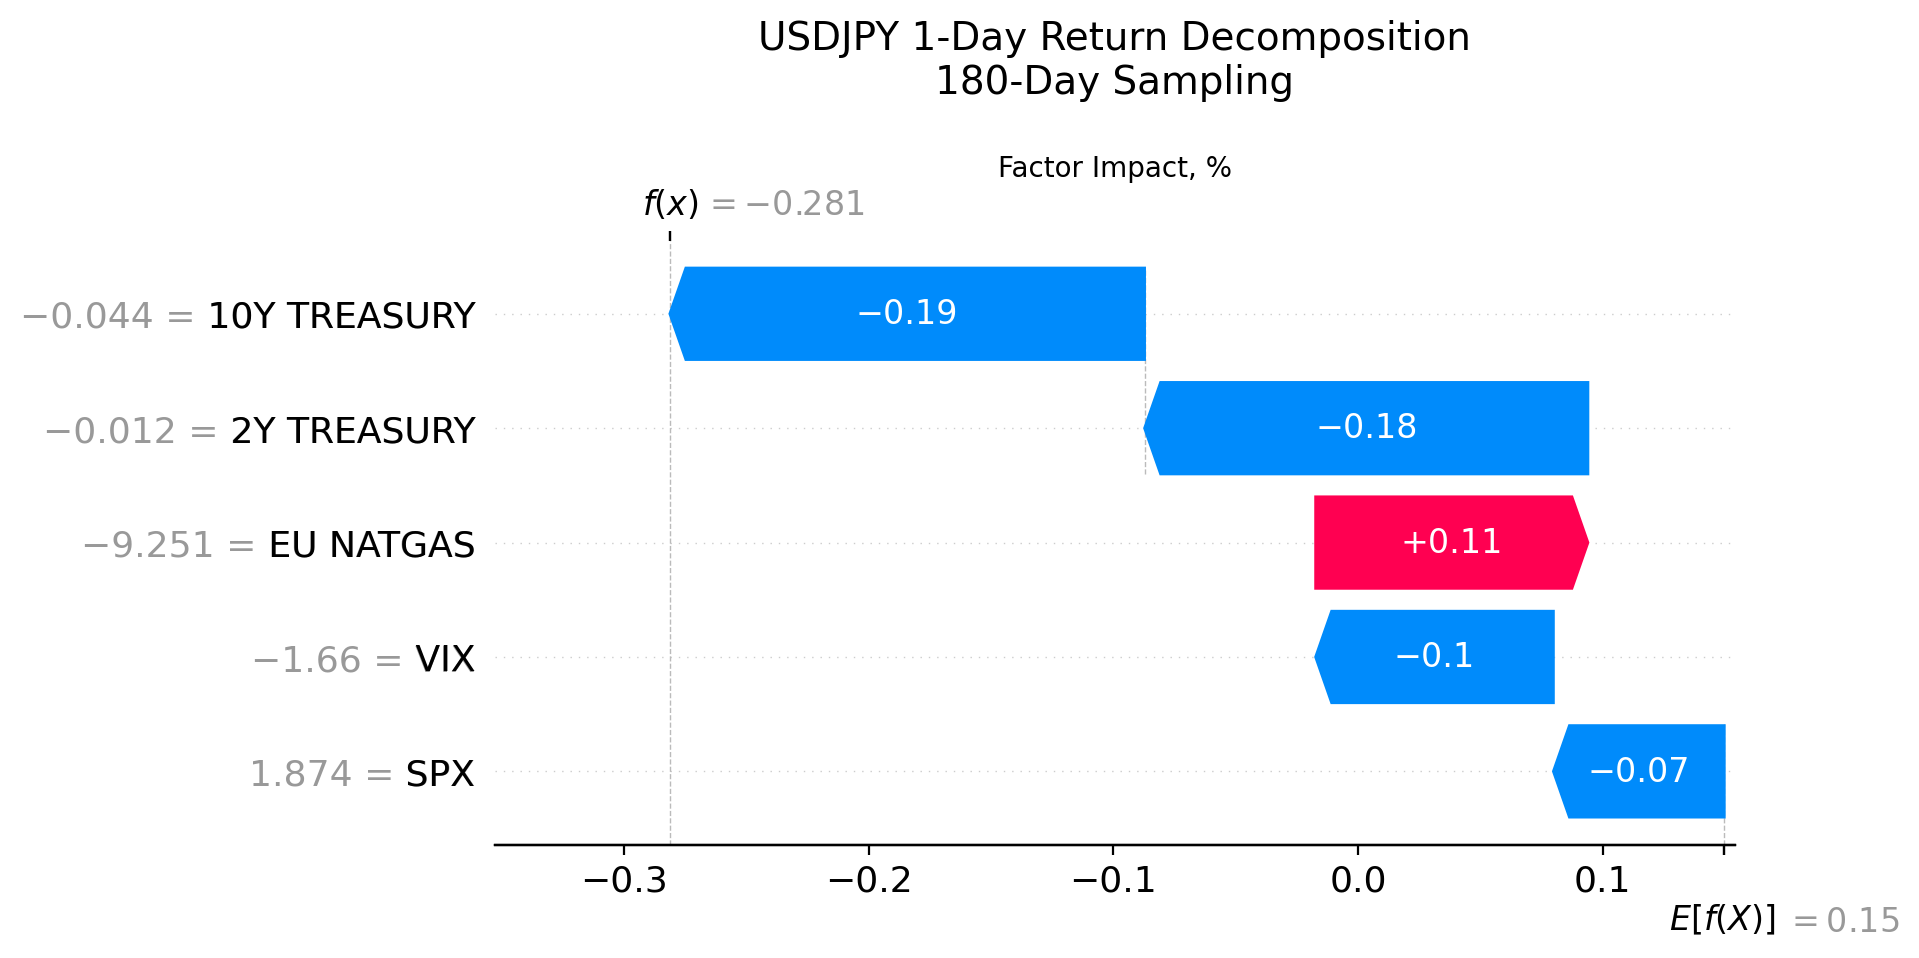

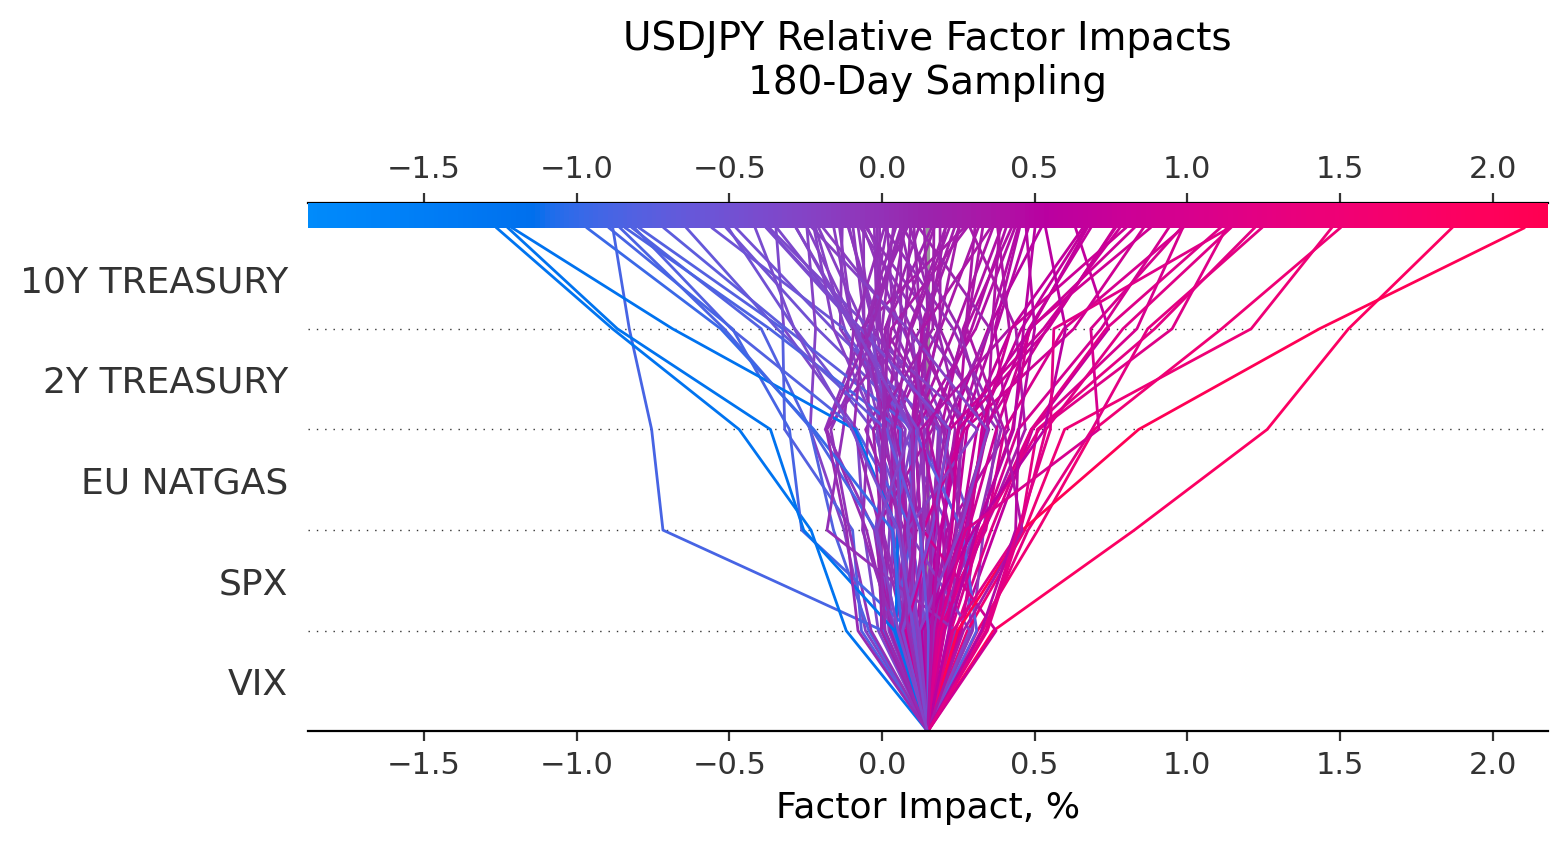

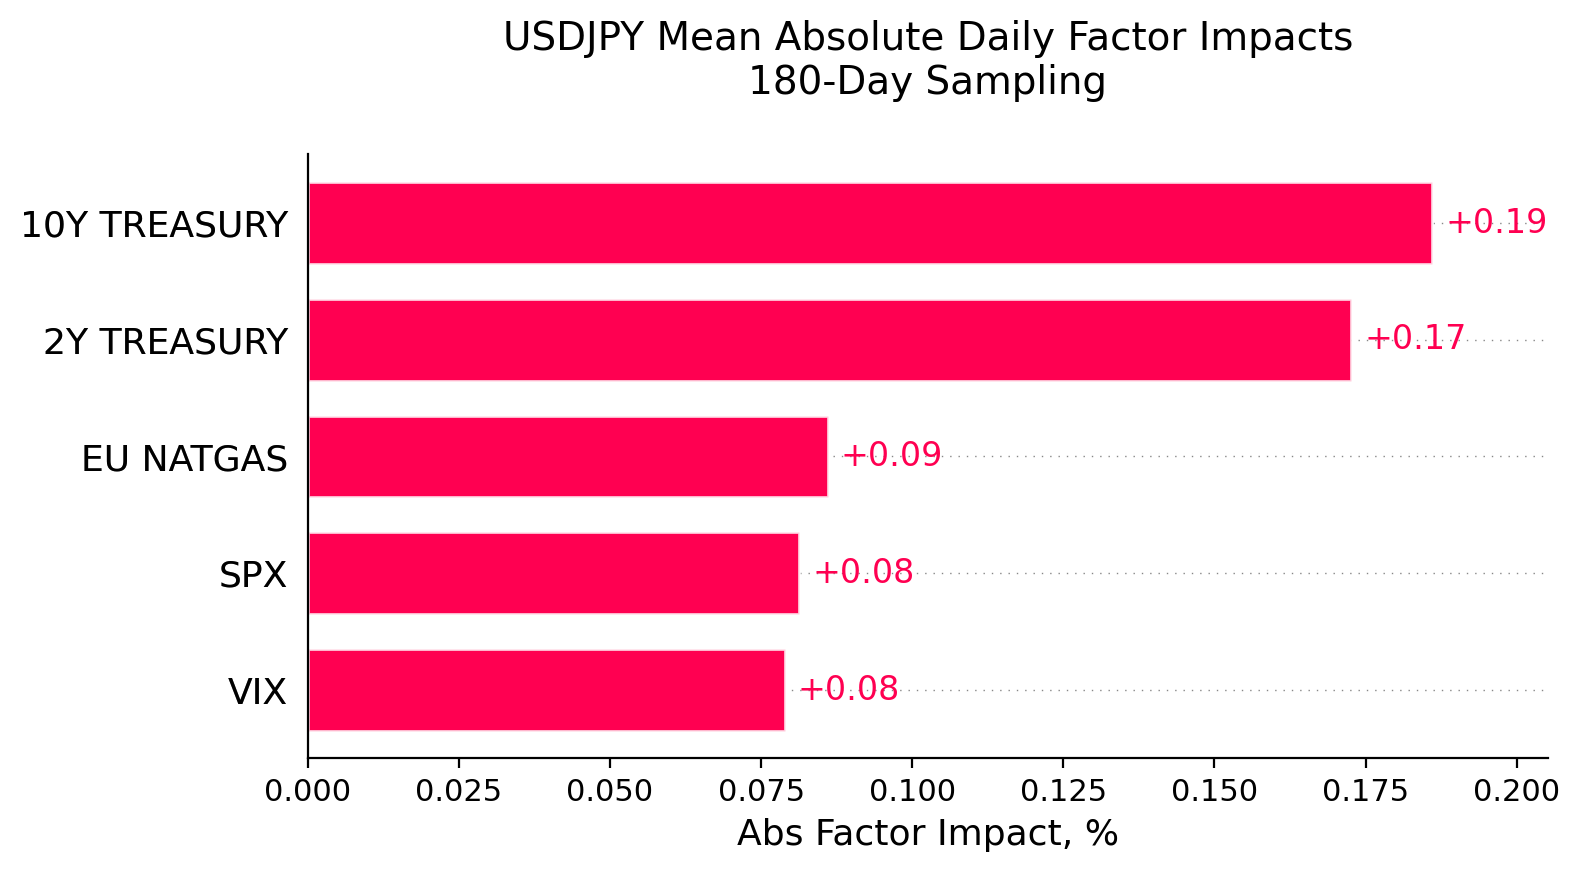

In [581]:
gradient_decomp(label = "USDJPY", tickers = factors_jpy, lookback_days = 180, names = names_jpy, log_flag = log_flag_jpy)

RMSE: 0.582 (0.141)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


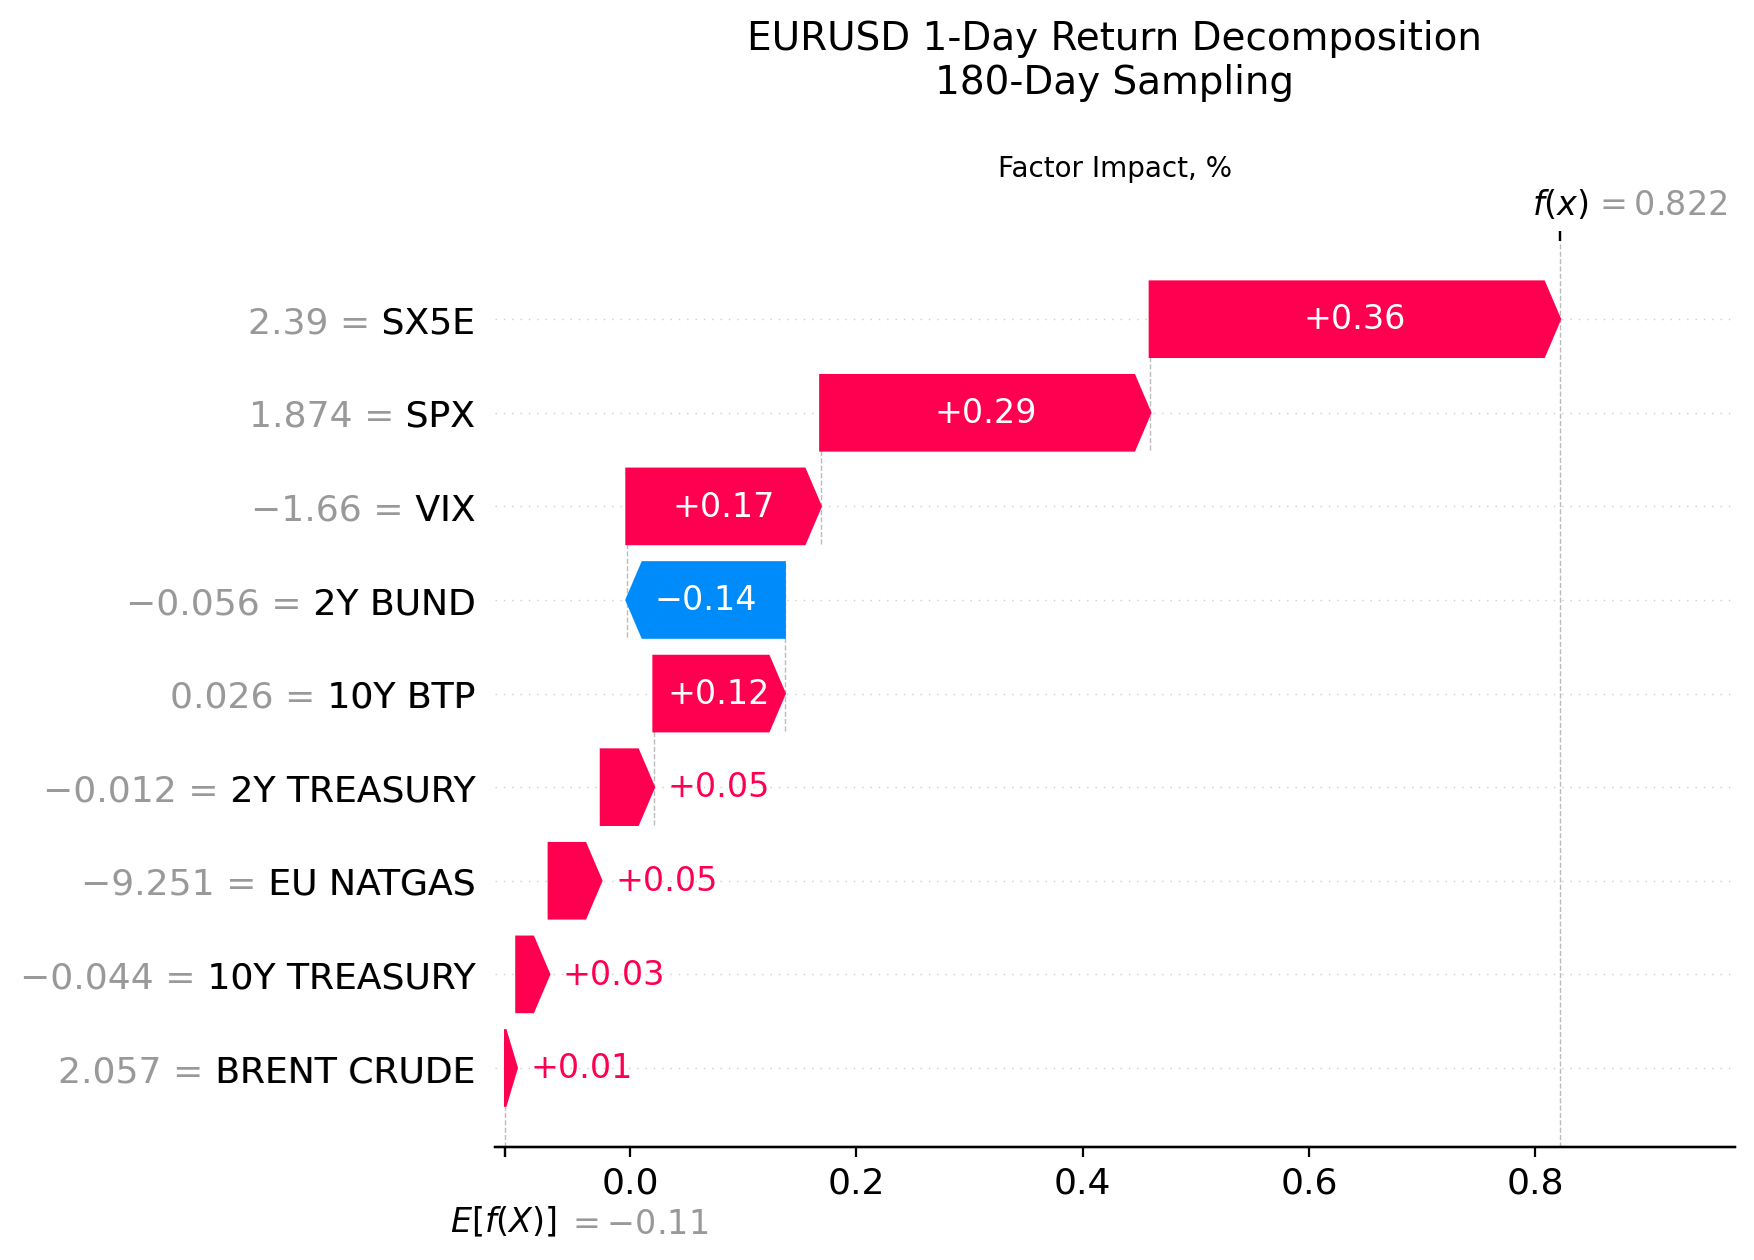

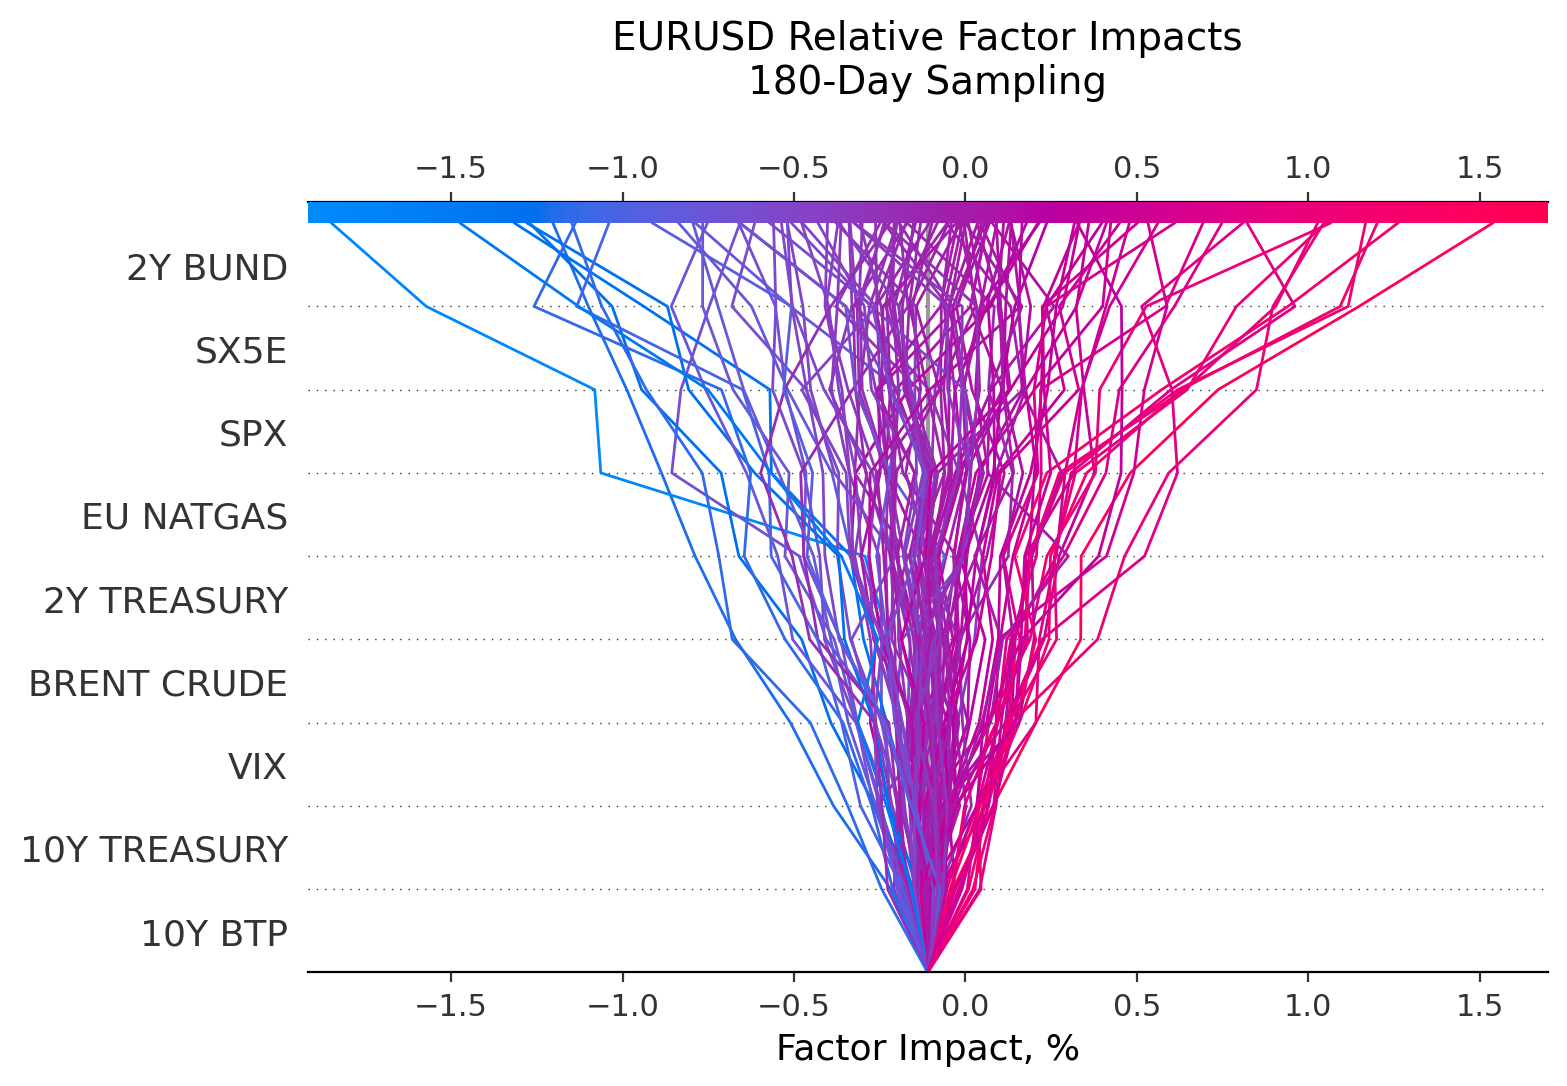

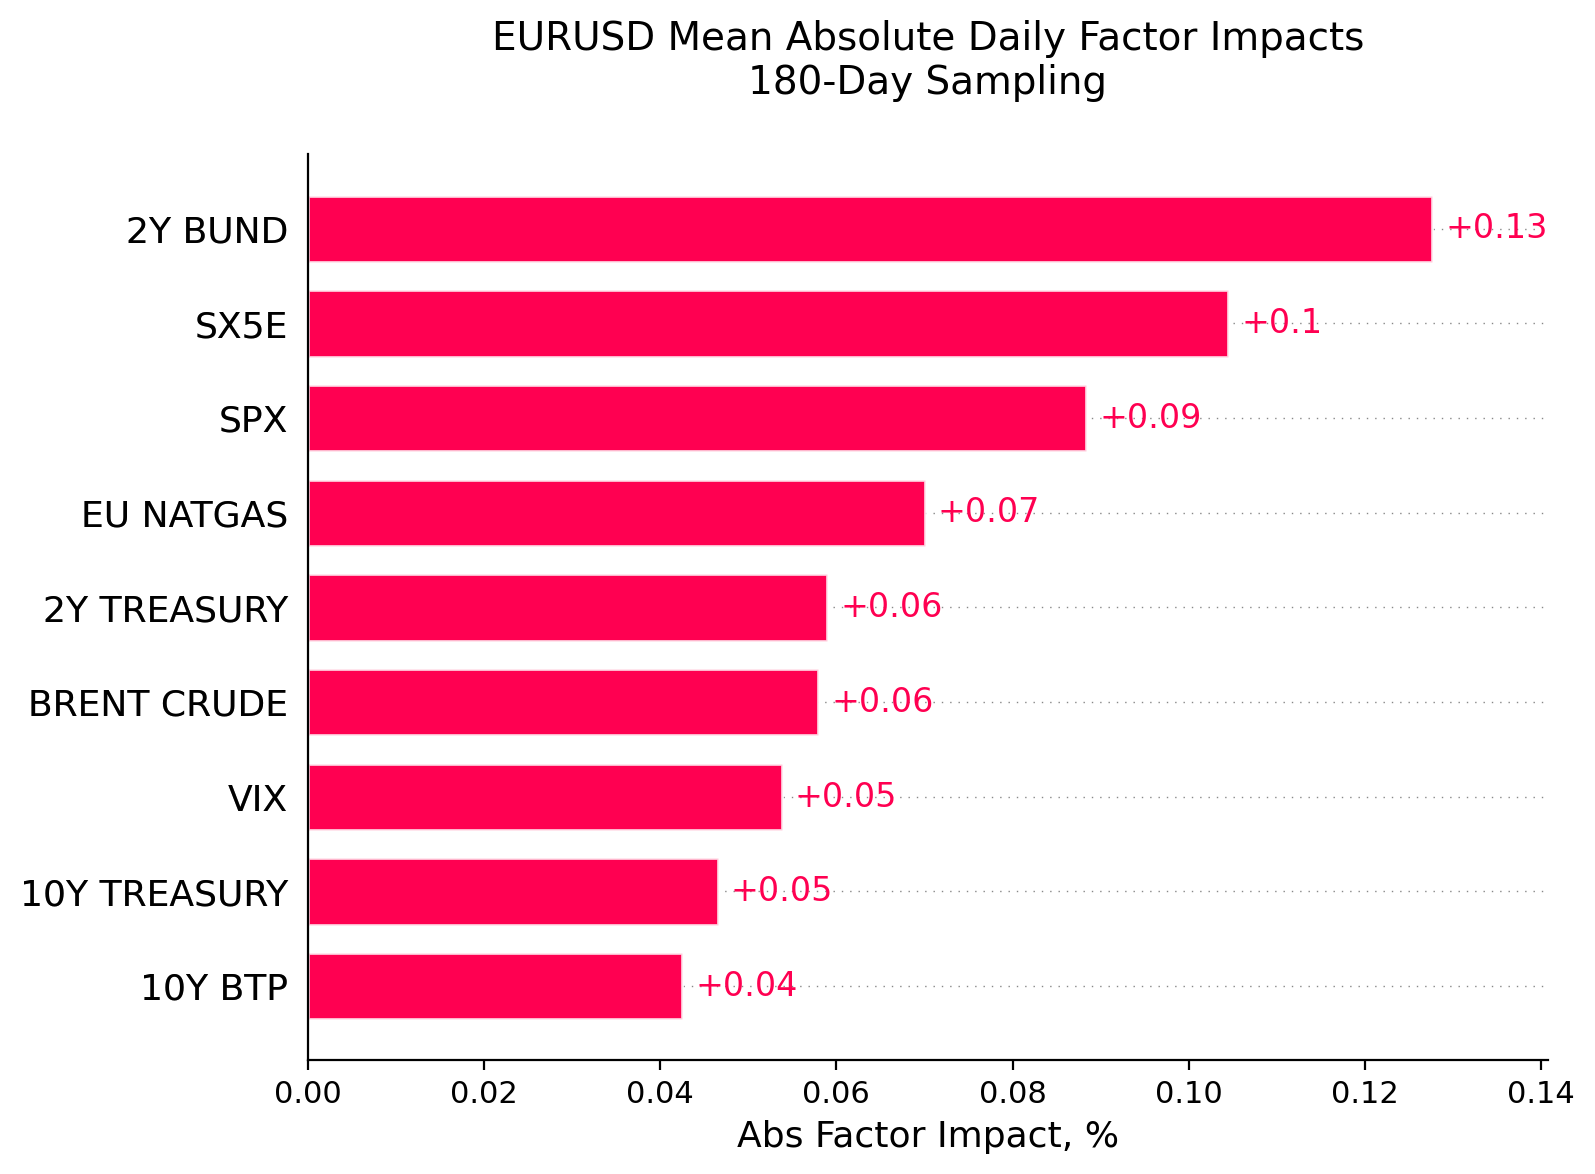

In [586]:
gradient_decomp(label = "EURUSD", tickers = factors_eur, lookback_days = 180, names = names_eur, log_flag = log_flag_eur)

RMSE: 0.666 (0.171)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


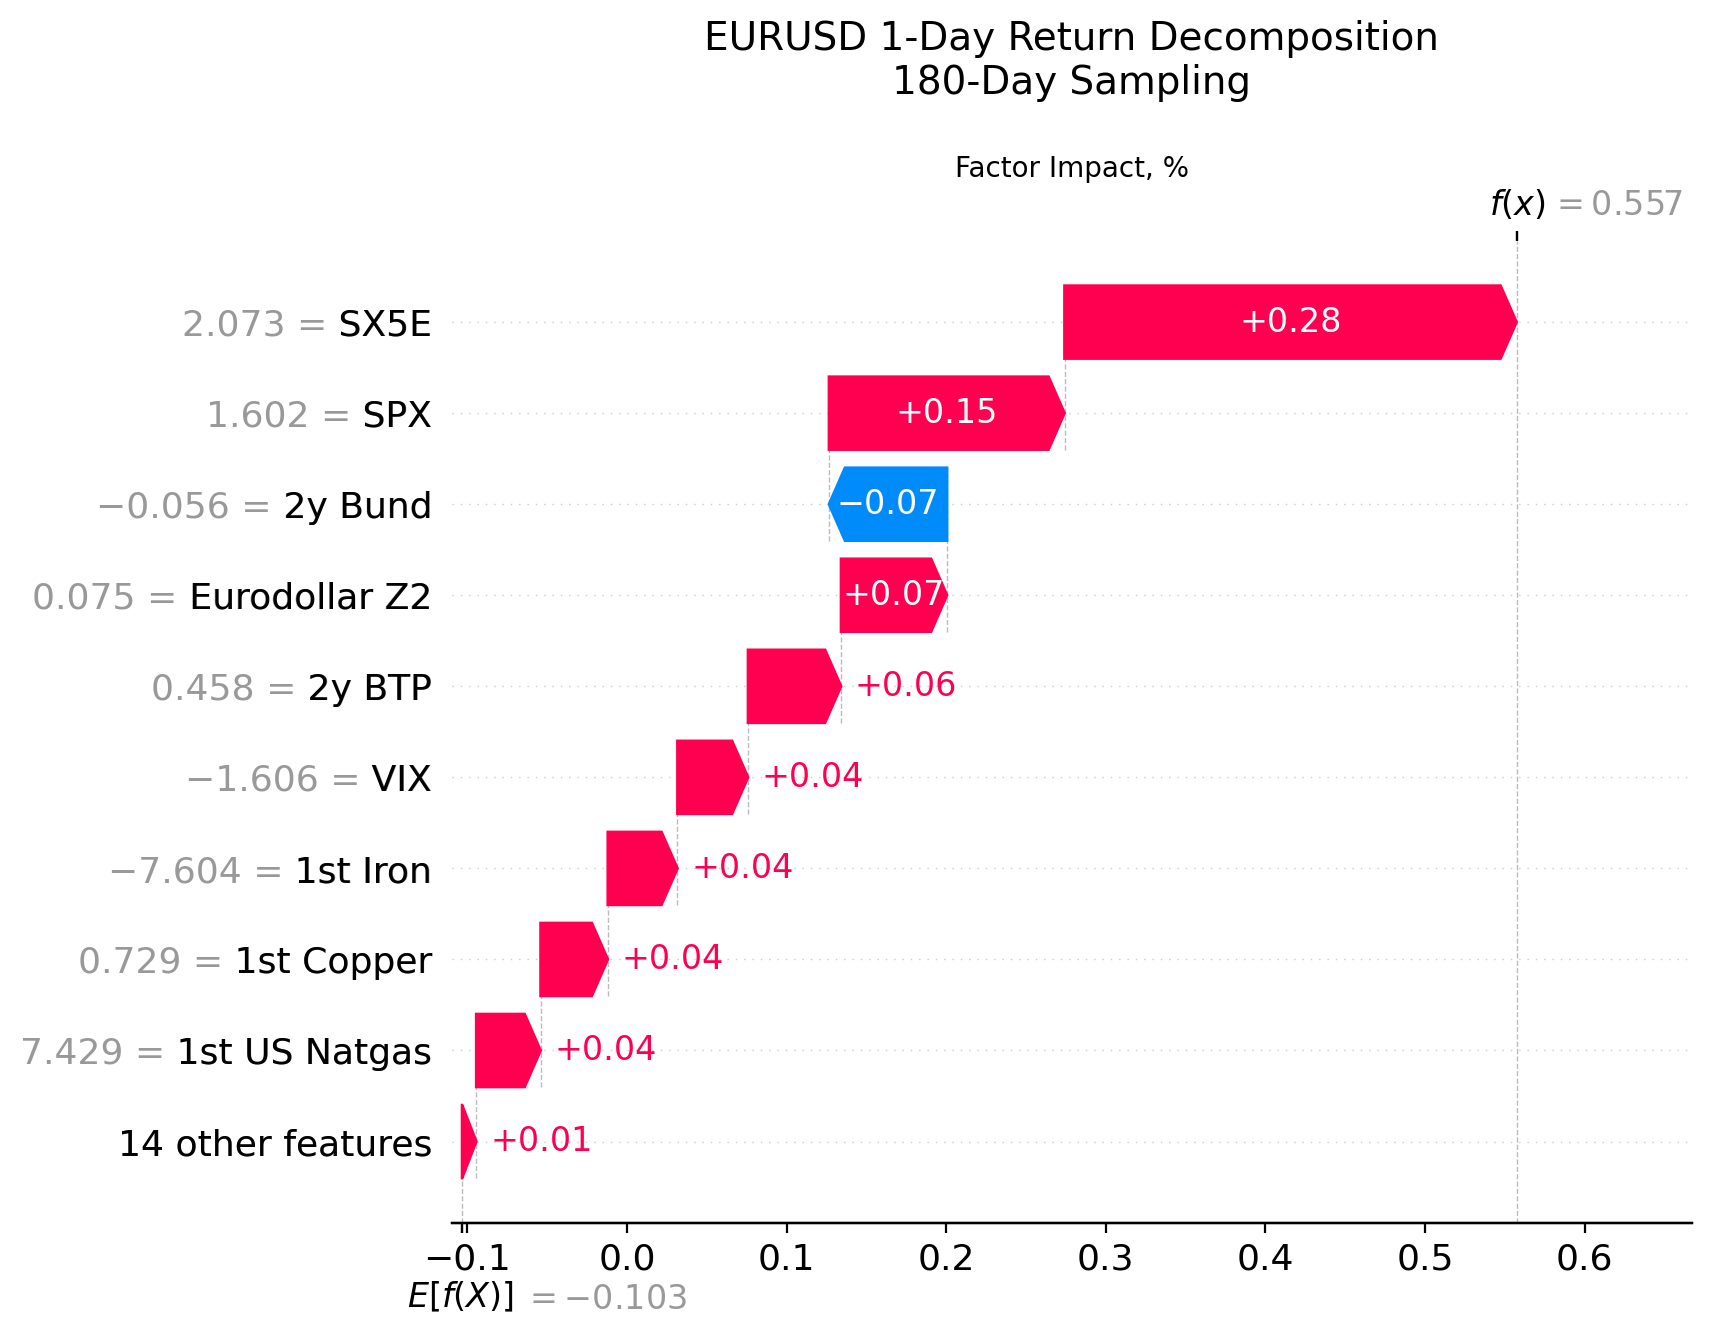

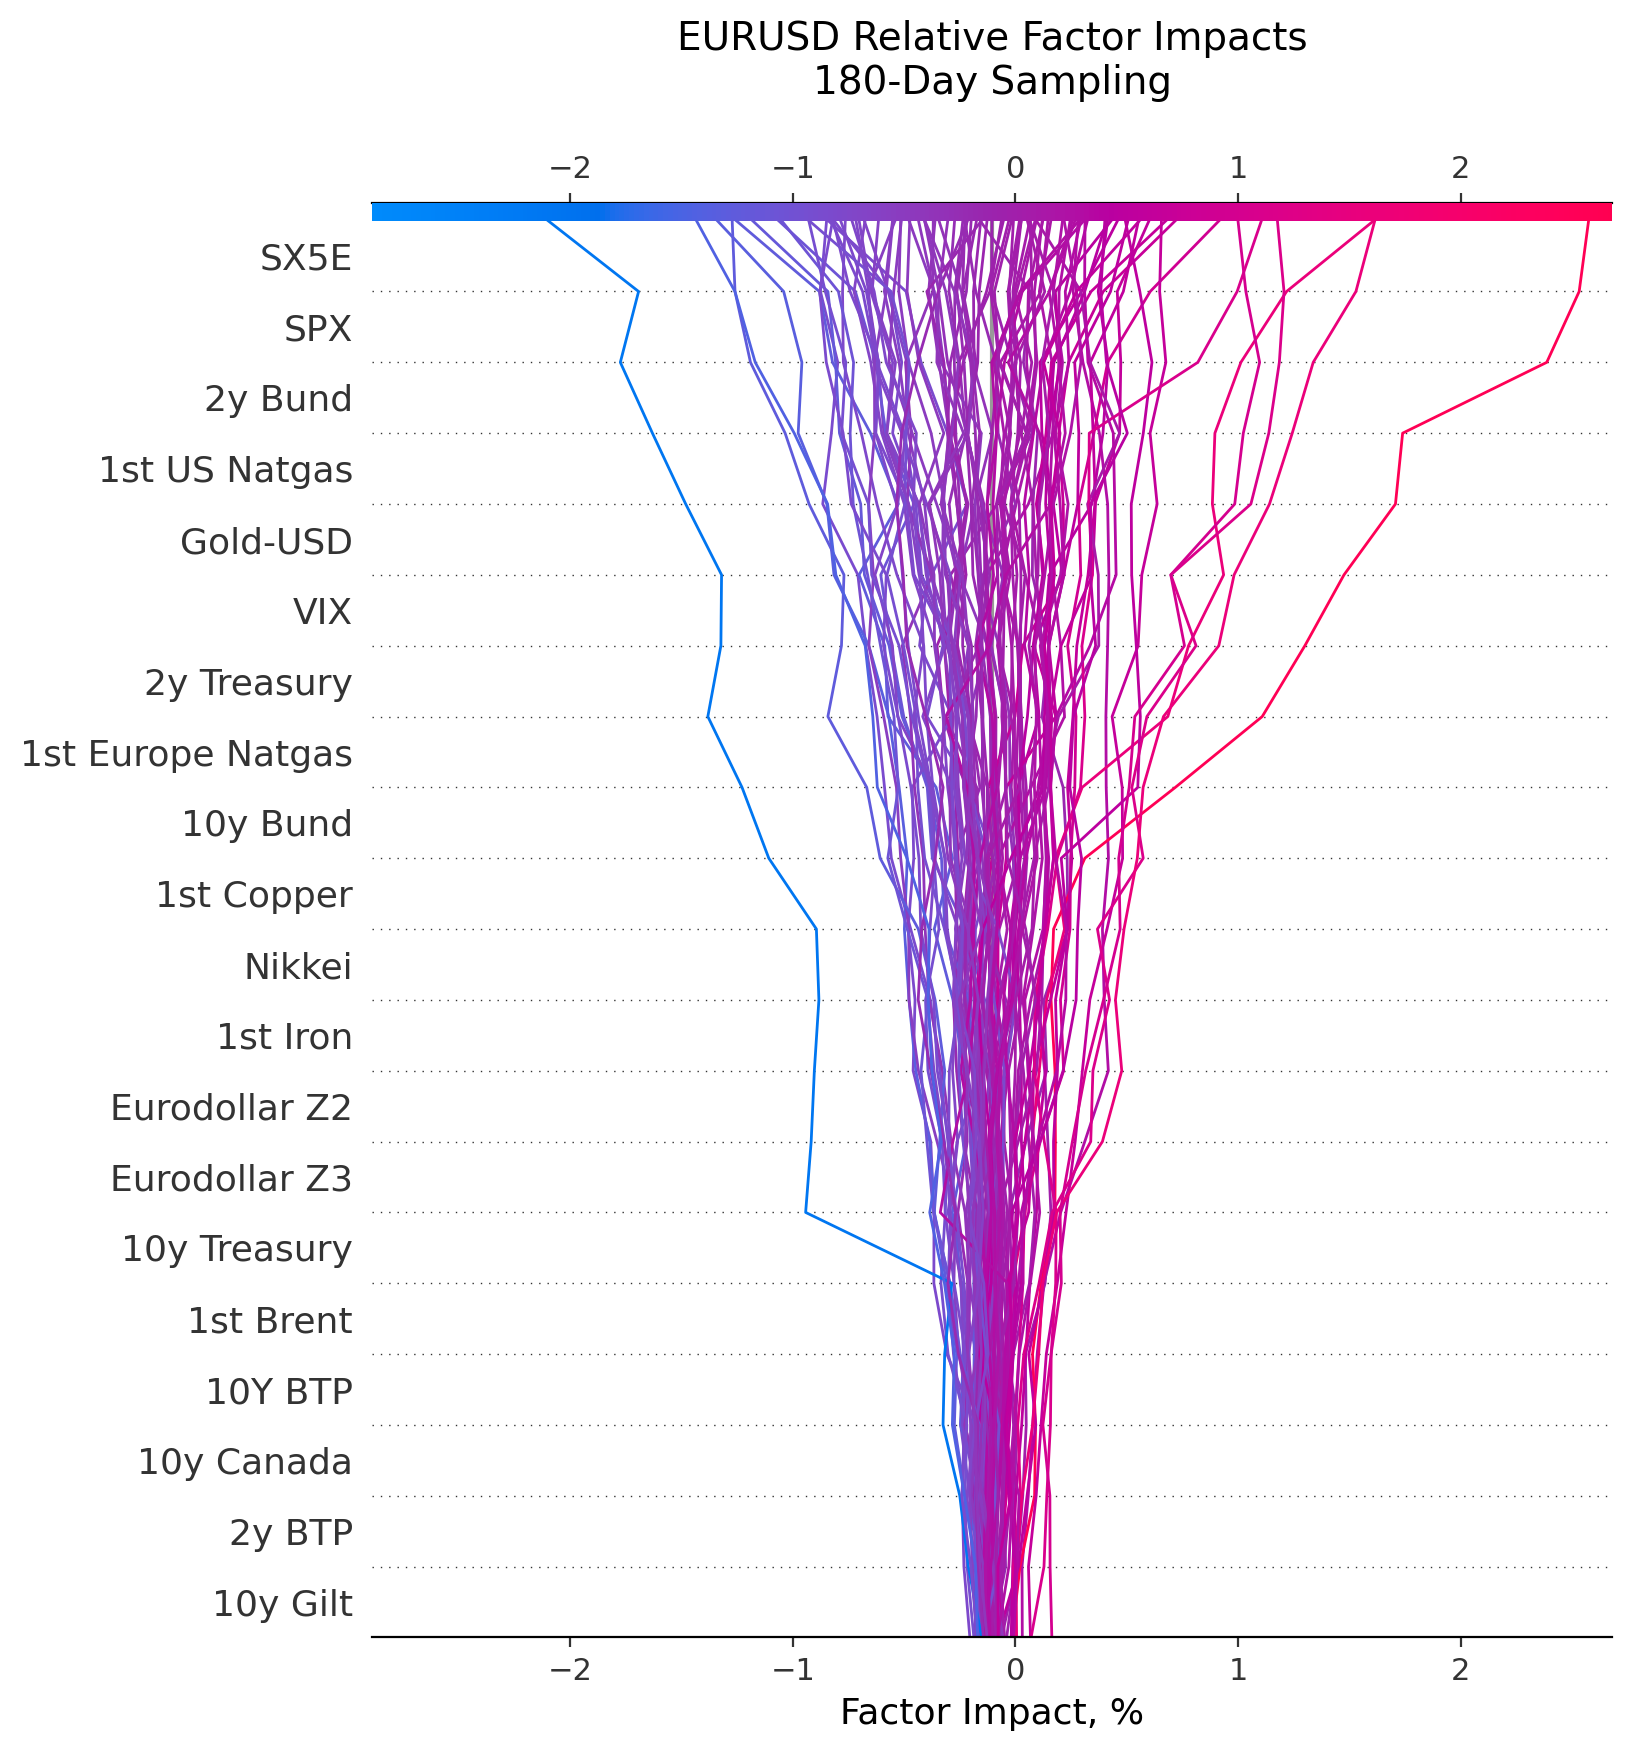

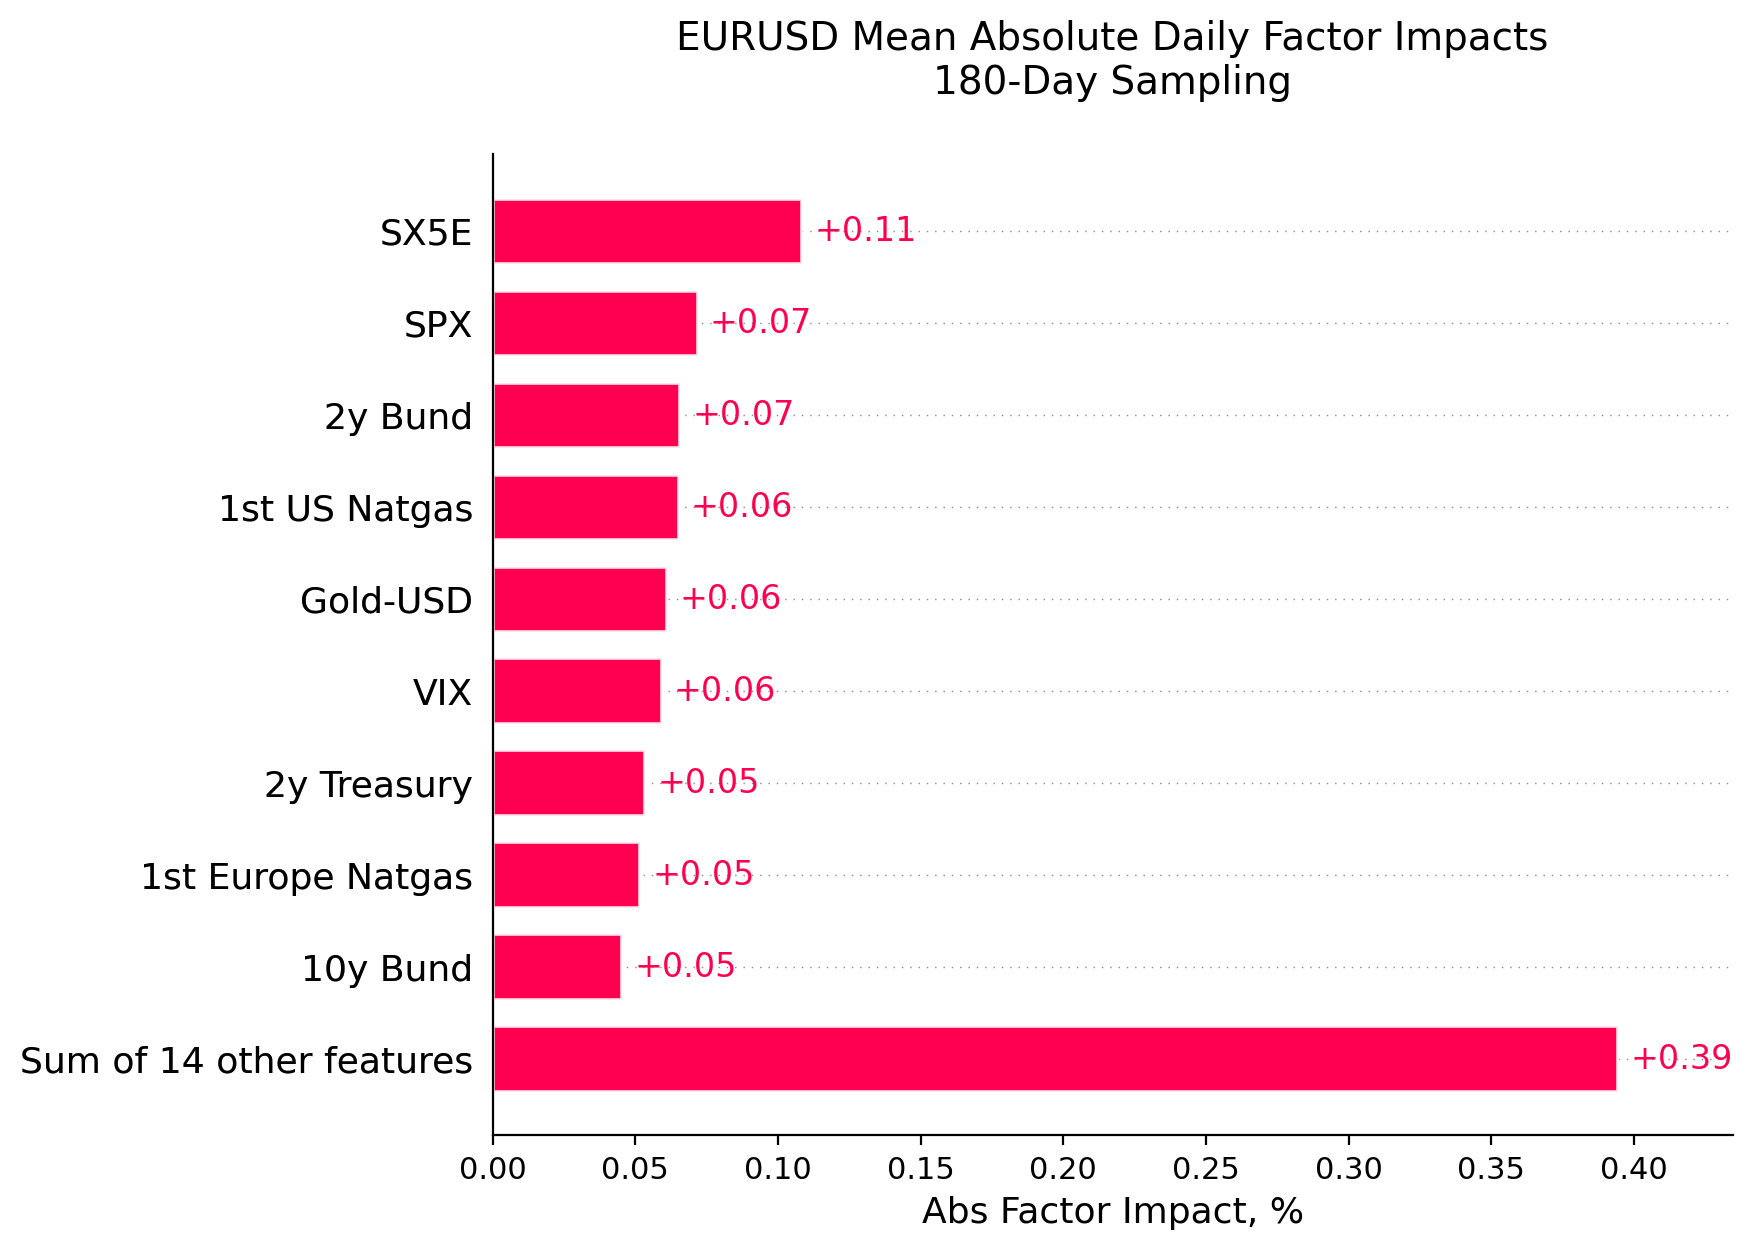

In [557]:
gradient_decomp(label = "EURUSD",
               tickers = factors_eur_large_DM,
               names = names_eur_large_DM,
               log_flag = log_flag_eur_large_DM,
               lookback_days = 180)